In [1]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import scipy
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

# Data standard scaler
from sklearn.preprocessing import StandardScaler

# Random train-test split
from sklearn.model_selection import train_test_split

# Metrics and model selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_predict

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from scipy.stats import ttest_ind

from networkx.algorithms import bipartite

#To visualize on of the RandomForest decision trees
#from sklearn import tree

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the data
<a class="anchor" id="load"></a>

In [3]:
DATA_PATH = './data'
MOVIE_PATH = os.path.join(DATA_PATH, 'american_movies_preprocessed.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'characters_preprocessed.tsv')
SCORE_PATH = os.path.join(DATA_PATH, 'score_function.tsv')

### 1.1 Characters data
<a class="anchor" id="load_characters"></a>

In [15]:
df_chars=pd.read_csv(CHAR_PATH, sep="\t")
df_chars['m_release_date']=pd.to_datetime(df_chars['m_release_date'], errors = 'coerce')
df_chars['min_year'].fillna(0, inplace=True)
df_chars.head(2)

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,m_genre_PCA,m_release_year,min_year
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,Ghosts of Mars,"Documentary, Culture & Society, Gay, Gay Interest",2001,0.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,Ghosts of Mars,"Documentary, Culture & Society, Gay, Gay Interest",2001,2000.0


### 1.2 The data score

In [16]:
df_numbers=pd.read_csv(SCORE_PATH, sep='\t').set_index('actor_name')
df_numbers.reset_index(inplace=True)
df_numbers.drop(['min_year'], axis=1, inplace=True)
df_numbers.head(2)

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,min_year_score
0,Jane Fonda,99.0,346.5,181.5,123.75,94.050000,75.900000,441.642857,243.803571,174.125000,...,36.229737,892.587692,462.089744,317.717532,244.955719,200.891379,171.213548,149.784285,133.531250,0
1,Clint Eastwood,348.0,174.0,460.0,729.00,1755.266667,1706.666667,1880.347619,1189.833333,1686.509524,...,3219.994472,2139.009068,1715.610398,1470.104342,3616.394846,2334.278040,1850.068876,1576.740235,1825.545952,0


# 2.1 Dataset preparation

In [17]:
df_chars_merged = df_chars.merge(df_numbers, on='actor_name', how='left').copy()
numbers_columns = df_numbers.columns[1:]
df_chars_merged[numbers_columns] = df_chars_merged[numbers_columns].fillna(0)
df_chars_merged['min_year'] = df_chars_merged['min_year'].astype('int')
df_chars_merged.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,min_year_score
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,Ghosts of Mars,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,Ghosts of Mars,...,34.200000,28.500000,24.428571,21.375000,19.000000,17.100000,15.545455,14.250000,13.153846,0.0
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,Ghosts of Mars,...,2146.828571,3255.369913,1990.897222,2641.254319,2432.196392,1729.285333,1391.918606,1179.534513,1029.515124,0.0
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,Ghosts of Mars,...,477.600000,715.333333,426.228571,311.050000,930.650794,546.942857,2009.549784,1152.650000,2576.304895,0.0
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,Ghosts of Mars,...,388.000000,261.583333,197.888889,159.400000,133.575758,115.023810,101.038462,90.111111,81.333333,0.0


In [18]:
nb_actors = df_chars_merged['actor_name'].nunique()
print("There are {} actors in this dataset.".format(nb_actors))

There are 34388 actors in this dataset.


In [19]:
df_chars_merged['is_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] == row['m_release_date'].year, axis=1).astype(int)
df_chars_merged['already_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] < row['m_release_date'].year and row['min_year']!=0, axis=1).astype(int)
df_chars_merged.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,2006,2007,2008,2009,2010,2011,2012,min_year_score,is_revealed,already_revealed
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,Ghosts of Mars,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,Ghosts of Mars,...,24.428571,21.375000,19.000000,17.100000,15.545455,14.250000,13.153846,0.0,0,1
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,Ghosts of Mars,...,1990.897222,2641.254319,2432.196392,1729.285333,1391.918606,1179.534513,1029.515124,0.0,0,1
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,Ghosts of Mars,...,426.228571,311.050000,930.650794,546.942857,2009.549784,1152.650000,2576.304895,0.0,0,1
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,Ghosts of Mars,...,197.888889,159.400000,133.575758,115.023810,101.038462,90.111111,81.333333,0.0,0,1


# 2.2 Movies that have a revelation

In [20]:
df_movie_revelation = df_chars_merged.groupby(['wikipedia_m_ID', 'm_release_date', 'm_genre_PCA']).agg({'is_revealed': 'sum', 'already_revealed':'sum'}).copy().reset_index()
df_movie_revelation['m_release_year'] = df_movie_revelation['m_release_date'].dt.year
df_movie_revelation.rename({'is_revealed' : 'has_revelation', 'already_revealed' : 'has_famous_actors'}, axis=1, inplace=True)
df_movie_revelation['has_revelation'] = (df_movie_revelation['has_revelation'] > 0).astype(int)
df_movie_revelation.head()

,wikipedia_m_ID,m_release_date,m_genre_PCA,has_revelation,has_famous_actors,m_release_year
0,3217,1992-10-09,"Gross-out film, Gross out, Comedy, Romance Film",1,0,1992
1,3333,1915-01-01,"Business, Gross out, Gross-out film, Computers",0,0,1915
2,3746,1982-06-25,"Anti-war film, Anti-war, Doomsday film, Apocal...",1,1,1982
3,3837,1974-02-07,"Action/Adventure, Action, Comedy, Action Thril...",0,0,1974
4,3947,1986-08-01,"Crime Thriller, Detective, Mystery, Detective ...",0,1,1986


In [21]:
df_movie_revelation['has_revelation'].value_counts()

0    22991
1     1859
Name: has_revelation, dtype: int64

In [22]:
nb_movies = df_movie_revelation['wikipedia_m_ID'].nunique()
nb_movies_revelation = df_movie_revelation['has_revelation'].value_counts()[1]
print("There are {} movies with a revelation which represents {:.2f}% of the movies.".format(nb_movies_revelation, nb_movies_revelation*100/nb_movies))
#df_movie_revelation = df_movie_revelation.loc[(df_movie_revelation['has_revelation'] > 0)]

There are 1859 movies with a revelation which represents 7.48% of the movies.


In [23]:
nb_movies_with_famous_actor = df_movie_revelation.loc[(df_movie_revelation['has_famous_actors']>0) & (df_movie_revelation['has_revelation']>0)].shape[0]
print("Among movies with a revelation, there are {} movies with at least one famous actor which represents {:.2f}% of the movies with revelation.".format(nb_movies_with_famous_actor, nb_movies_with_famous_actor*100/nb_movies_revelation))

Among movies with a revelation, there are 1490 movies with at least one famous actor which represents 80.15% of the movies with revelation.


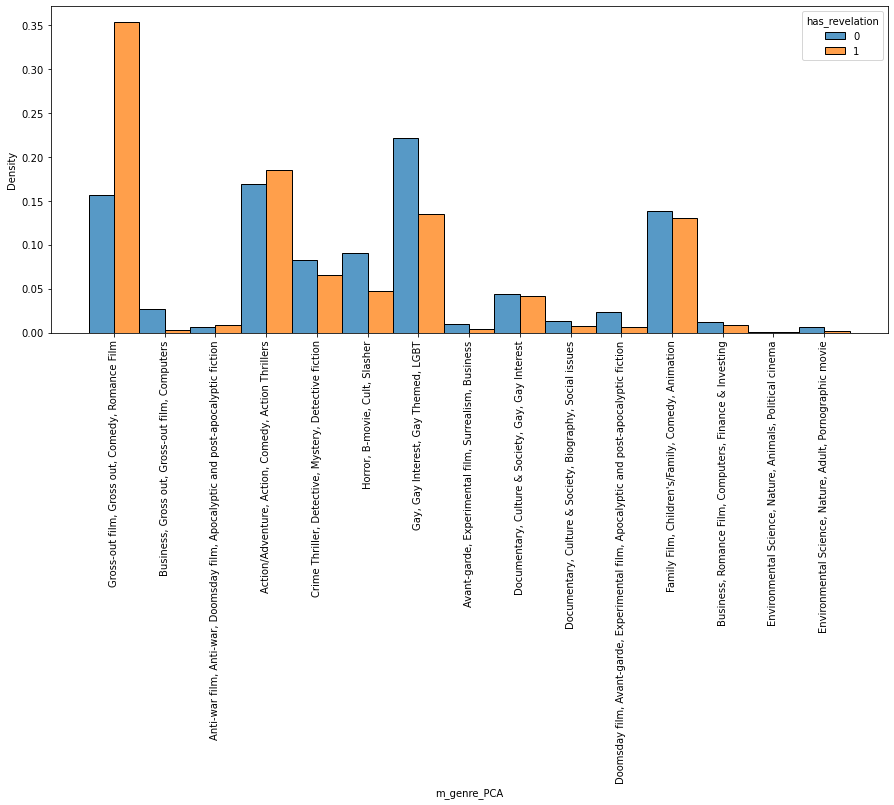

In [24]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df_movie_revelation, x='m_genre_PCA', hue='has_revelation', multiple="dodge", stat='density', common_norm=False)
plt.xticks(rotation=90);

In [25]:
#For the movie with no famous actor, the revelation must come from another factor than co-acting.
#Therefore, we decided to only focus on movies that had at least one actor, to analyse co-acting impact.
df_movie_revelation = df_movie_revelation.loc[(df_movie_revelation['has_famous_actors'] > 0)]
df_movie_revelation.head()

,wikipedia_m_ID,m_release_date,m_genre_PCA,has_revelation,has_famous_actors,m_release_year
2,3746,1982-06-25,"Anti-war film, Anti-war, Doomsday film, Apocal...",1,1,1982
4,3947,1986-08-01,"Crime Thriller, Detective, Mystery, Detective ...",0,1,1986
6,4231,1992-07-31,"Horror, B-movie, Cult, Slasher",0,2,1992
7,4560,1995-05-18,"Gross-out film, Gross out, Comedy, Romance Film",0,1,1995
8,4726,1989-06-19,"Action/Adventure, Action, Comedy, Action Thril...",0,3,1989


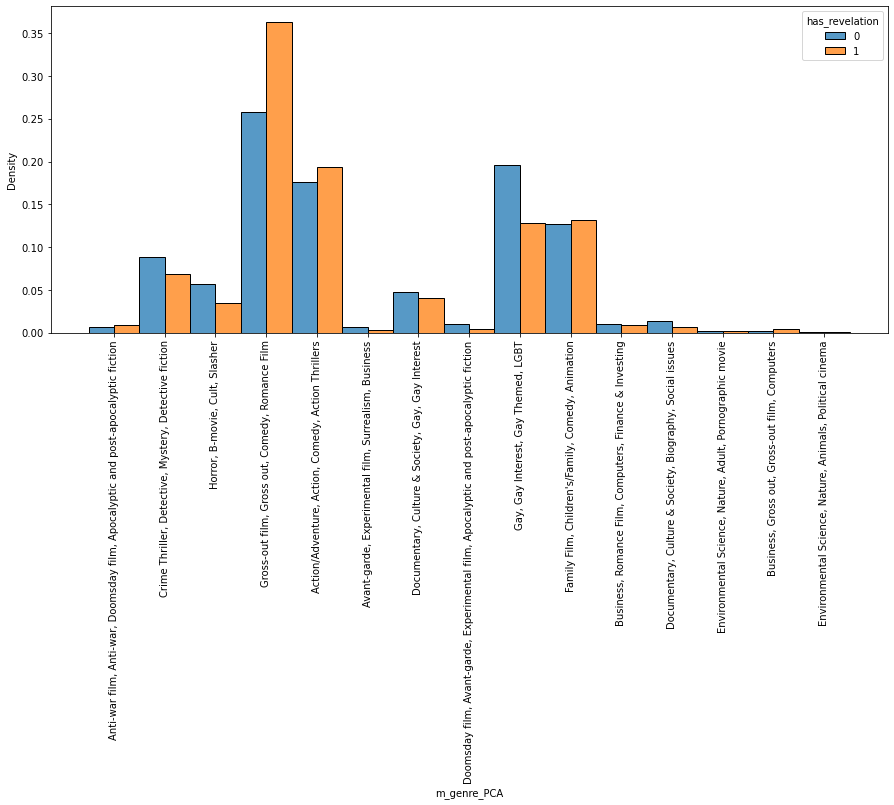

In [26]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df_movie_revelation, x='m_genre_PCA', hue='has_revelation', multiple="dodge", stat='density', common_norm=False)
plt.xticks(rotation=90);

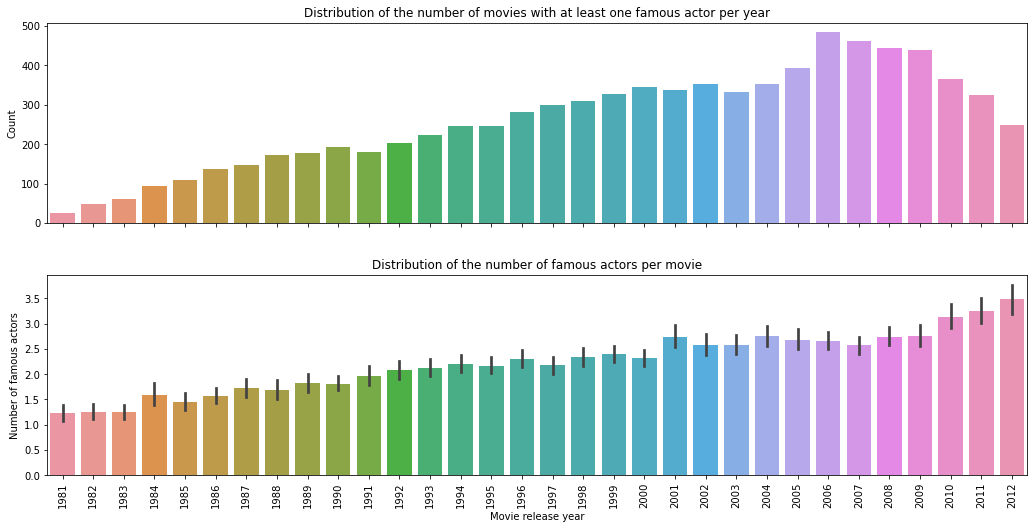

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
data_grouped = df_movie_revelation.groupby('m_release_year')['wikipedia_m_ID'].count().reset_index()
ax = axs[0]
sns.barplot(data=data_grouped,x='m_release_year', y='wikipedia_m_ID', ax=ax)
ax.set_title("Distribution of the number of movies with at least one famous actor per year")
ax.set_xlabel('')
ax.set_ylabel('Count')

ax = axs[1]
sns.barplot(data=df_movie_revelation,x='m_release_year', y='has_famous_actors', ax=ax)
ax.set_title("Distribution of the number of famous actors per movie")
plt.xticks(rotation = 90)
fig.tight_layout(pad=3.0)
ax.set_xlabel('Movie release year')
ax.set_ylabel('Number of famous actors')
plt.show()

As it can be seen, there is an increase in the number of movies per year but also a major increase in the number of famous actors per movie.
The second observation can be due to two facts:
* The global increase in the number of movies
* The scoring system: once you've been releaved, you stay famous. But the earlier we are, the less information we have about actors that were releaved before 1980 but for whom we don't have an accurate score.

For those two reasons, the time period will be split into 6 blocks, so that movies with comparable number of famous actors will be compared.

# 2.2 Revelation per pentade

In [28]:
nb_five_years_lower = range(1982, 2008,5)
nb_five_years_upper = range(1987, 2013, 5)

In [29]:
def define_popularity(min_year, lower_bound, upper_bound):
    if not min_year or min_year >= upper_bound:
        return 'unknown'
    if min_year < lower_bound:
        return 'famous'
    else:
        return 'revelation'

In [30]:
df_chars_revelation = df_movie_revelation.merge(df_chars_merged, on=['wikipedia_m_ID', 'm_release_date', 'm_genre_PCA'], how='inner').copy()
df_revelations_five_years = dict()
for y_lower, y_upper in zip(nb_five_years_lower, nb_five_years_upper):
    filter_conditions = (
        (df_chars_revelation['m_release_date'].dt.year >= y_lower) & 
        (df_chars_revelation['m_release_date'].dt.year < y_upper)
    )
    columns = ['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA','actor_name', 'is_revealed', 'already_revealed', 'min_year']
    df_filtered = df_chars_revelation.loc[filter_conditions, columns].copy()
    df_filtered['popularity'] = df_filtered['min_year'].apply(lambda x: define_popularity(x, y_lower, y_upper))
    df_revelations_five_years.update({range(y_lower, y_upper): df_filtered.copy()})

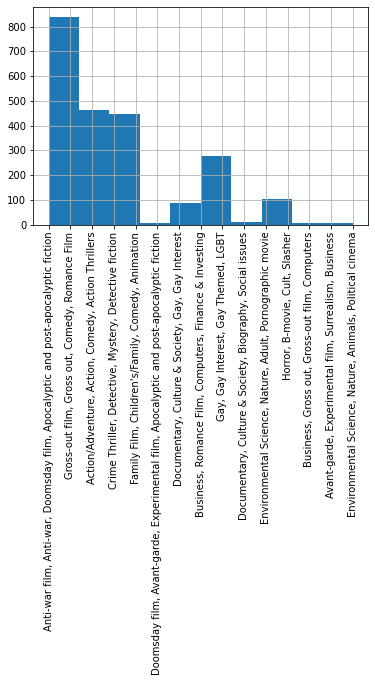

In [31]:
df_chars_revelation[df_chars_revelation['is_revealed'] == 1]['m_genre_PCA'].hist()
plt.xticks(rotation=90);

In [32]:
df_movie_revelation['m_genre_PCA'].value_counts().index[:7]

Index(['Gross-out film, Gross out, Comedy, Romance Film',
       'Gay, Gay Interest, Gay Themed, LGBT',
       'Action/Adventure, Action, Comedy, Action Thrillers',
       'Family Film, Children's/Family, Comedy, Animation',
       'Crime Thriller, Detective, Mystery, Detective fiction',
       'Horror, B-movie, Cult, Slasher',
       'Documentary, Culture & Society, Gay, Gay Interest'],
      dtype='object')

In [33]:
df_revelations_five_years[range(1982,1987)]

,wikipedia_m_ID,m_name,m_release_date,m_genre_PCA,actor_name,is_revealed,already_revealed,min_year,popularity
0,3746,Blade Runner,1982-06-25,"Anti-war film, Anti-war, Doomsday film, Apocal...",William Sanderson,0,0,0,unknown
1,3746,Blade Runner,1982-06-25,"Anti-war film, Anti-war, Doomsday film, Apocal...",Harrison Ford,0,1,1980,famous
2,3746,Blade Runner,1982-06-25,"Anti-war film, Anti-war, Doomsday film, Apocal...",Rutger Hauer,0,0,1985,revelation
3,3746,Blade Runner,1982-06-25,"Anti-war film, Anti-war, Doomsday film, Apocal...",Sean Young,1,0,1982,revelation
4,3746,Blade Runner,1982-06-25,"Anti-war film, Anti-war, Doomsday film, Apocal...",Daryl Hannah,0,0,1984,revelation
...,...,...,...,...,...,...,...,...,...
85369,34152774,The Bad Seed,1985-02-07,"Crime Thriller, Detective, Mystery, Detective ...",Michael Beck,0,0,0,unknown
85370,34152774,The Bad Seed,1985-02-07,"Crime Thriller, Detective, Mystery, Detective ...",Blair Brown,0,1,1981,famous
85371,34152774,The Bad Seed,1985-02-07,"Crime Thriller, Detective, Mystery, Detective ...",Richard Kiley,0,0,0,unknown
85372,34152774,The Bad Seed,1985-02-07,"Crime Thriller, Detective, Mystery, Detective ...",Lynn Redgrave,0,0,0,unknown


In [34]:
df_chars_revelation['m_genre_PCA'].value_counts()

Gross-out film, Gross out, Comedy, Romance Film                                            26439
Action/Adventure, Action, Comedy, Action Thrillers                                         15878
Gay, Gay Interest, Gay Themed, LGBT                                                        14277
Family Film, Children's/Family, Comedy, Animation                                          11850
Crime Thriller, Detective, Mystery, Detective fiction                                       6728
Horror, B-movie, Cult, Slasher                                                              3826
Documentary, Culture & Society, Gay, Gay Interest                                           3306
Documentary, Culture & Society, Biography, Social issues                                     999
Business, Romance Film, Computers, Finance & Investing                                       838
Doomsday film, Avant-garde, Experimental film, Apocalyptic and post-apocalyptic fiction      701
Anti-war film, Anti-war, Dooms

In [35]:
def get_attributes(df_, graph_, previous_score):
    df_revelation = df_.merge(graph_.drop_duplicates('actor_name_x', keep='first'), left_on='actor_name', right_on='actor_name_x', how='inner')[['actor_name', 'min_year', 'popularity']]
    revelation = df_revelation.drop_duplicates(keep='first').set_index('actor_name').to_dict('index')
    
    df_famous = df_.merge(graph_.drop_duplicates('actor_name_y', keep='first'), left_on='actor_name', right_on='actor_name_y', how='inner')[['actor_name', 'min_year', 'popularity' , '{}'.format(previous_score)]]
    famous = df_famous.drop_duplicates(keep='first').set_index('actor_name').to_dict('index')
    
    attrs_ = dict()
    attrs_.update(revelation)
    attrs_.update(famous)
    
    return revelation, famous, attrs_

In [36]:
def create_bipartite_graph(revelation, famous, attrs_, graph_):
    B = nx.Graph()
    B.add_nodes_from(revelation, bipartite=0)
    B.add_nodes_from(famous, bipartite=1)
    B.add_weighted_edges_from([(row['actor_name_x'], row['actor_name_y'], 1) for idx, row in graph_.iterrows()], weight='weight')

    colors = []
    for node in B:
        val = attrs_[node]['popularity']
        if val =='revelation':
            colors.append("green")
        elif val =='famous':
            colors.append("red")
        else:
            colors.append("gray")
    
    pos = {node:[0, i] for i,node in enumerate(revelation.keys())}
    pos.update({node:[1, i] for i,node in enumerate(famous.keys())})
    
    bipartite_graph = {'graph': B, 'pos': pos, 'node_color':colors}
    
    return bipartite_graph

In [44]:
def extract_partition_nodes(G: nx.Graph, attrs_, partition: str):
    nodeset = [x for x in G.nodes if attrs_[x]['popularity'] == partition]
    if partition != "revelation" and partition!="famous":
        raise Exception(f"No nodes exist in the partition {partition}!")
    return nodeset

In [64]:
def retrieve_career_boosters(graph_, previous_score, attrs_):
    revelations_ = extract_partition_nodes(graph_,attrs_, "revelation")
    famous_ = extract_partition_nodes(graph_, attrs_, "famous")
    
    sources = revelations_
    targets = revelations_
    measures = dict()
    measures=['betweenness_centrality_subset', 'degree_centrality']
    
    bc_subset = nx.betweenness_centrality_subset(graph_, sources=sources, targets=targets)
    cc_subset = nx.degree_centrality(graph_)
    
    sorted_bc = sorted(bc_subset.items(), key=lambda kv: kv[1], reverse=True)
    sorted_cc = sorted(cc_subset.items(), key=lambda kv: kv[1], reverse=True)
    career_boosters_bc = []
    career_boosters_cc = []
    for (x, m) in sorted_bc:
        if attrs_[x]['popularity']=='famous':
            score = attrs_[x]['{}'.format(previous_score)]
            min_year = attrs_[x]['min_year']
            bc_measure = m
            cc_measure = cc_subset[x]
            famous_actor = {'actor_name':x, 'score_in_{}'.format(previous_score):score, 'revealed_in':min_year, 'betweenness_centrality_subset':bc_measure, 'degree_centrality':cc_measure}
            career_boosters_bc.append(famous_actor)
    for (x, m) in sorted_cc:
        if attrs_[x]['popularity']=='famous':
            score = attrs_[x]['{}'.format(previous_score)]
            min_year = attrs_[x]['min_year']
            bc_measure = bc_subset[x]
            cc_measure = m
            famous_actor = {'actor_name':x, 'score_in_{}'.format(previous_score):score, 'revealed_in':min_year, 'betweenness_centrality_subset':bc_measure, 'degree_centrality':cc_measure}
            career_boosters_cc.append(famous_actor)
    
    return career_boosters_bc, career_boosters_cc

In [69]:
def compute_career_boosters_infos(df_, graph_, range_y, m_genre):
    career_booster_infos = dict()
    for i, x in enumerate(df_[:5], start=1):
        key = x['actor_name']
        score = x['score_in_{}'.format(range_y.start-1)]
        min_year = x['revealed_in']
        ranking = i
        casting = graph_[graph_['actor_name_y'] == key]
        nb_actors_boosted_at_revelation = casting[casting['is_revealed_x'] == 1].shape[0]
        nb_actors_boosted_before_revelation = casting[casting['is_revealed_x'] == 0].shape[0]
        nb_actors_boosted = casting.shape[0]
        tmp_booster = {'booster_in': range_y,
                       'm_genre': m_genre,
                       'ranking': i,
                       'actor_score_before_period': score,
                       'nb_actors_boosted': nb_actors_boosted,
                       'nb_actors_boosted_at_revelation': nb_actors_boosted_at_revelation,
                       'nb_actors_boosted_before_revelation': nb_actors_boosted_before_revelation
        }
        career_booster_infos.update({key: tmp_booster})
    career_boosters_info_df = pd.DataFrame.from_dict(career_booster_infos, orient='index')
    return career_boosters_info_df

In [72]:
def carreer_booster_retrieval_for_all_genres():

    graphs = dict()
    famous_ranking_bc = dict()
    famous_ranking_cc = dict()
    booster_bc = dict()
    booster_cc = dict()

    for y_lower, y_upper in zip(nb_five_years_lower, nb_five_years_upper):
        tmp_range = range(y_lower, y_upper)
        df_tmp = df_revelations_five_years[tmp_range].copy()
        df_tmp = df_tmp.merge(df_numbers[['actor_name', '{}'.format(y_lower-1)]], on='actor_name', how='left')
        df_tmp['{}'.format(y_lower-1)] = df_tmp['{}'.format(y_lower-1)].fillna(0)

        graph = pd.merge(df_tmp, df_tmp, on=['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA'])
        filter_conditions = (
            (graph.popularity_x == 'revelation') & 
            (graph.popularity_y == 'famous') &
            (graph.m_release_date.dt.year <= graph.min_year_x)
        )
        graph = graph.loc[filter_conditions]
        #print(df_tmp)
        
        unique_genres = df_tmp['m_genre_PCA'].unique()
        genre_iteration = ['all'] + list(unique_genres)
        
        graphs_genre = dict()
        famous_ranking_bc_genre = dict()
        famous_ranking_cc_genre = dict()
        booster_bc_genre = dict()
        booster_cc_genre = dict()
        
        for genre in genre_iteration:
            graph_genre = graph.copy()
            df_genre = df_tmp.copy()
            #print(genre)
            if genre !='all':
                #print("there")
                filter_conditions = (
                    (graph_genre.m_genre_PCA == genre)
                )
                graph_genre = graph.loc[filter_conditions]
                filter_conditions = (
                    (df_genre.m_genre_PCA == genre)
                )
                df_genre = df_genre.loc[filter_conditions]
            #print(df_genre)
            revelation_attributes, famous_attributes, attrs = get_attributes(df_genre, graph_genre, y_lower-1)
            #print(attrs)

            tmp_graph = create_bipartite_graph(revelation_attributes, famous_attributes, attrs, graph_genre)
            graphs_genre.update({genre: tmp_graph})
            #print(tmp_graph)

            tmp_famous_ranking_bc, tmp_famous_ranking_cc = retrieve_career_boosters(tmp_graph['graph'], y_lower-1, attrs)
            famous_ranking_bc_genre.update({genre: tmp_famous_ranking_bc})
            famous_ranking_cc_genre.update({genre: tmp_famous_ranking_cc})

            tmp_career_booster_bc = compute_career_boosters_infos(tmp_famous_ranking_bc[:5], graph_genre, tmp_range, genre)
            booster_bc_genre.update({genre: tmp_career_booster_bc})

            tmp_career_booster_cc = compute_career_boosters_infos(tmp_famous_ranking_cc[:5], graph_genre, tmp_range, genre)
            booster_cc_genre.update({genre: tmp_career_booster_cc})
            
        graphs.update({tmp_range: graphs_genre})
        famous_ranking_bc.update({tmp_range: famous_ranking_bc_genre})
        famous_ranking_cc.update({tmp_range: famous_ranking_cc_genre})
        booster_bc.update({tmp_range: booster_bc_genre})
        booster_cc.update({tmp_range: booster_cc_genre})
        
    return booster_bc, booster_cc


In [73]:
career_booster_bc = dict()
career_booster_cc = dict()

career_booster_bc, career_booster_cc = carreer_booster_retrieval_for_all_genres()

In [81]:
career_booster_cc

{range(1982, 1987): {'all':                                   booster_in m_genre  ranking  \
  Dennis Quaid  (1982, 1983, 1984, 1985, 1986)     all        1   
  Chevy Chase   (1982, 1983, 1984, 1985, 1986)     all        2   
  Dan Aykroyd   (1982, 1983, 1984, 1985, 1986)     all        3   
  William Hurt  (1982, 1983, 1984, 1985, 1986)     all        4   
  Kurt Russell  (1982, 1983, 1984, 1985, 1986)     all        5   
  
                actor_score_before_period  nb_actors_boosted  \
  Dennis Quaid                      250.0                 13   
  Chevy Chase                       885.0                 13   
  Dan Aykroyd                       198.0                  9   
  William Hurt                      240.5                  9   
  Kurt Russell                      142.0                  8   
  
                nb_actors_boosted_at_revelation  \
  Dennis Quaid                               12   
  Chevy Chase                                 8   
  Dan Aykroyd                

In [80]:
career_booster_bc.to_json("career_booster_bc.json")  
career_booster_cc.to_json("career_booster_cc.json")  

AttributeError: 'dict' object has no attribute 'to_json'

In [ ]:
graphs = dict()
famous_ranking_bc = dict()
famous_ranking_cc = dict()
career_booster_bc = dict()
career_booster_cc = dict()

for y_lower, y_upper in zip(nb_five_years_lower, nb_five_years_upper):
    tmp_range = range(y_lower, y_upper)
    df_tmp = df_revelations_five_years[tmp_range].copy()
    df_tmp = df_tmp.merge(df_numbers[['actor_name', '{}'.format(y_lower-1)]], on='actor_name', how='left')
    df_tmp['{}'.format(y_lower-1)] = df_tmp['{}'.format(y_lower-1)].fillna(0)
    
    graph = pd.merge(df_tmp, df_tmp, on=['wikipedia_m_ID', 'm_name', 'm_release_date'])
    filter_conditions = (
        (graph.popularity_x == 'revelation') & 
        (graph.popularity_y == 'famous') &
        (graph.m_release_date.dt.year <= graph.min_year_x)
    )
    graph = graph.loc[filter_conditions]
    
    revelation_attributes, famous_attributes, attrs = get_attributes(df_tmp, graph, y_lower-1)
    
    tmp_graph = create_bipartite_graph(revelation_attributes, famous_attributes, attrs, graph)
    graphs.update({tmp_range: tmp_graph})
    
    tmp_famous_ranking_bc, tmp_famous_ranking_cc = retrieve_career_boosters(tmp_graph['graph'], y_lower-1, attrs)
    famous_ranking_bc.update({tmp_range: tmp_famous_ranking_bc})
    famous_ranking_cc.update({tmp_range: tmp_famous_ranking_cc})
    
    tmp_career_booster_bc = compute_career_boosters_infos(tmp_famous_ranking_bc[:5], graph, tmp_range)
    tmp_career_booster_bc_df = pd.DataFrame.from_dict(tmp_career_booster_bc, orient='index')
    
    career_booster_bc.update({tmp_range: tmp_career_booster_bc_df})
    
    
    
    tmp_career_booster_cc = compute_career_boosters_infos(tmp_famous_ranking_cc[:5], graph, tmp_range)
    career_booster_cc.update({tmp_range: tmp_career_booster_cc})
    

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(20, 15))
for i, year in enumerate(graphs):
    G = graphs[year]['graph']
    pos = graphs[year]['pos']
    node_color = graphs[year]['node_color']
    #ix = np.unravel_index(i, axs.shape)
    #plt.sca(axs[ix])
    nx.draw(G, pos=pos, node_color=node_color, with_labels=False, node_size=10, ax=axs[i])
    axs[i].set_title("Period: {}-{}".format(year.start, year.stop))
    
fig.suptitle('Graph of the relations between revelation actors (in green) and famous actors (in red) before the first are revealed')

plt.scatter([],[], c=['green'], label='Revelations')
plt.scatter([],[], c=['red'], label='Famous actors')

plt.legend()
plt.show()

fig.tight_layout()

In [ ]:
for k_year, v_year in career_booster.items():
    print("\nRESULTS FOR PERIOD: {}-{}".format(k_year.start, k_year.stop))
    print ("{:<5}: {:<18} {:<6} {:<17} {:<32} {:<5}".format('rank', 'name', 'score', 'nb_actors_boosted', 'nb_actors_boosted_at_revelation', 'nb_actors_boosted_before_revelation'))
    for k_actor, v_actor in v_year.items():
        boosted_in, ranking, actor_score_before_period, nb_actors_boosted, nb_actors_boosted_at_revelation, nb_actors_boosted_before_revelation = v_actor.values()
        print ("{:<5}: {:<18} {:<6} {:<17} {:<32} {:<5}".format(ranking, k_actor, round(actor_score_before_period), nb_actors_boosted, nb_actors_boosted_at_revelation, nb_actors_boosted_before_revelation))